## Imports & Setup

In [1]:
# Imports
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 2

# imports
import collections
import copy
import datetime
import functools
import inspect
import io
import itertools
import math
import os
import pathlib
import pdb
import random
import shutil
import subprocess
import sys
import tempfile
import time
import typing
import warnings
import zipfile
from pathlib import Path
from pprint import pprint as ppr

import dotenv
import einops

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Data management libraries.
import nibabel as nib
import nibabel.processing

# Computation & ML libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import scipy
from box import Box
from icecream import ic
from natsort import natsorted

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)

In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True)

direnv: loading ~/Projects/pitn/.envrc

EnvironmentNameNotFound: Could not find conda environment: pitn
You can list all discoverable environments with `conda info --envs`.




True

In [3]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash

In [4]:
# cap is defined in an ipython magic command
try:
    print(cap)
except NameError:
    pass

Author: Tyler Spears

Last updated: 2023-05-16T10:42:25.287174-04:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.4.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.19.0-41-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: ced2fa19b02a5e1bdcda004d6ed4440c3d8bd269

skimage   : 0.19.3
sys       : 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]
scipy     : 1.9.3
einops    : 0.6.0
matplotlib: 3.5.2
pandas    : 1.5.2
numpy     : 1.23.4
nibabel   : 3.2.2
seaborn   : 0.12.1
pitn      : 0.0.post1.dev258+g67cc03c.d20230208




## Data Loading

In [17]:
subj_dir = Path("/data/srv/outputs/pitn/vcu/preproc")
assert subj_dir.exists()

subj_list = (
    "P_01",
    "P_02",
    "P_03",
    "P_04",
    "P_05",
    "P_06",
    "P_07",
    "P_08",
    "P_10",
    "P_11",
    "P_13",
    "P_14",
    # "P_16",
    "P_19",
    "P_20",
    "P_21",
    "P_22",
    "P_23",
    "P_24",
    "P_25",
    "P_26",
    "P_27",
    "P_29",
    "P_33",
    "P_34",
    "P_37",
)

decel_subjs = {"P_03", "P_20", "P_21", "P_25", "P_29"}

In [6]:
subj_data = Box(default_box=True)

for subj_id in subj_list:
    subj_dict = Box(default_box=True)
    d = subj_dir / subj_id
    assert d.exists()

    d_diff = subj_dict.files.diffusion
    d_diff.dwi = d / "diffusion" / f"{subj_id}_dwi.nii.gz"
    d_diff.lesion_mask = d / "diffusion" / "ms_lesion_mask.nii.gz"
    d_diff.mask = d / "diffusion" / "dwi_mask.nii.gz"
    d_diff.wm_mask = (
        d
        / "diffusion"
        / "freesurfer_segmentations_reg-dwi"
        / "mrtrix_5tt/roi_masks"
        / "white_matter.nii.gz"
    )

    param_maps = d_diff.param_maps
    for p in (d / "diffusion" / "parameter_maps").glob("*"):
        p_group_name = p.name
        for im in p.glob("*.nii.gz"):
            im_name = im.name.replace("".join(im.suffixes), "")
            if "model_fit" in im_name:
                continue
            param_maps[p_group_name][im_name] = im

    d_diff.param_maps = param_maps

    subj_dict.files.diffusion = d_diff

    subj_data[subj_id] = subj_dict

In [7]:
data_table = {
    "subj_id": list(),
    "subj_group": list(),
    "group": list(),
    "metric_name": list(),
    "tissue_type": list(),
    "param_mean": list(),
    "param_std": list(),
}
stats_table = {
    "subj_id": list(),
    "subj_group": list(),
    "group": list(),
    "metric_name": list(),
    "stat_name": list(),
    "stat_value": list(),
    "dof": list(),
}
voxel_vol = 1.875 * 1.875 * 2
for subj_id in subj_list:
    print(subj_id)
    d = subj_data[subj_id]
    lesion_mask = nib.load(d.files.diffusion.lesion_mask).get_fdata().astype(bool)
    wm_mask = nib.load(d.files.diffusion.wm_mask).get_fdata().astype(bool)
    wm_mask = wm_mask * (~lesion_mask)

    for g, p in d.files.diffusion.param_maps.items():
        for p_name, p_f in p.items():
            p_im = nib.load(p_f).get_fdata().astype(np.float32)
            # Ignore multi-dimensional parameters for now.
            if len(p_im.shape) == 4:
                continue
            for l, a in zip(("nawm", "lesion"), (p_im[wm_mask], p_im[lesion_mask])):
                data_table["subj_id"].append(subj_id)
                if subj_id in decel_subjs:
                    data_table["subj_group"].append("decel.")
                else:
                    data_table["subj_group"].append("non-decel")
                data_table["group"].append(g)
                data_table["metric_name"].append(p_name)
                data_table["tissue_type"].append(l)
                a = a[~np.isnan(a)]
                data_table["param_mean"].append(a.mean())
                data_table["param_std"].append(a.std())
                if np.isnan(data_table["param_mean"][-1]).any() or np.isnan(
                    data_table["param_std"][-1].any()
                ):
                    print(g, p_name, l, "has NaN")
                    print(np.isnan(a).sum(), "/", np.prod(a.shape))

            # t-statistic calculation
            wm_vox = p_im[wm_mask]
            lesion_vox = p_im[lesion_mask]
            x_bar_wm = wm_vox.mean()
            x_bar_lesion = lesion_vox.mean()
            var_bar_wm = np.var(wm_vox, ddof=1)
            var_bar_lesion = np.var(lesion_vox, ddof=1)
            n_wm = wm_vox.shape[0]
            n_lesion = lesion_vox.shape[0]
            t = x_bar_wm - x_bar_lesion / (
                np.sqrt(
                    var_bar_wm / wm_vox.shape[0] + var_bar_lesion / lesion_vox.shape[0]
                )
            )
            dof = ((var_bar_wm / n_wm + var_bar_lesion / n_lesion) ** 2) / (
                (var_bar_wm / n_wm) ** 2 / (n_wm - 1)
                + (var_bar_lesion / n_lesion) ** 2 / (n_lesion - 1)
            )

            stats_table["subj_id"].append(subj_id)
            if subj_id in {"P_03", "P_20", "P_21", "P_25", "P_29"}:
                stats_table["subj_group"].append("decel.")
            else:
                stats_table["subj_group"].append("non-decel")
            stats_table["group"].append(g)
            stats_table["metric_name"].append(p_name)
            stats_table["stat_name"].append("Welchs_t_stat")
            stats_table["stat_value"].append(t)
            stats_table["dof"].append(dof)

    lesion_vol = lesion_mask.sum() * voxel_vol
    wm_vol = wm_mask.sum() * voxel_vol
    for l, a in zip(("nawm", "lesion"), (wm_vol, lesion_vol)):
        data_table["subj_id"].append(subj_id)
        if subj_id in decel_subjs:
            data_table["subj_group"].append("decel.")
        else:
            data_table["subj_group"].append("non-decel")
        data_table["group"].append("shape")
        data_table["metric_name"].append("volume mm^3")
        data_table["tissue_type"].append(l)
        data_table["param_mean"].append(a)
        data_table["param_std"].append(0)

data_table_bak = pd.DataFrame.from_dict(data_table)
data_table = data_table_bak.copy(deep=True)

# Rename some of the crazier names.
data_table.loc[
    data_table.metric_name == "wm-Watson-bundle_odi",
    "metric_name",
] = "odi"
data_table.loc[
    data_table.metric_name == "partial_volume_fraction_wm-intra-cellular-Watson-bundle",
    "metric_name",
] = "pvf_ic"
data_table.loc[
    data_table.metric_name == "partial_volume_fraction_csf-isotropic-ball",
    "metric_name",
] = "pvf_iso"
data_table.loc[
    data_table.metric_name
    == "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle",
    "metric_name",
] = "pvf_ic-stick"

stats_table_bak = pd.DataFrame.from_dict(stats_table)
stats_table = stats_table_bak.copy(deep=True)

stats_table.loc[
    stats_table.metric_name == "wm-Watson-bundle_odi",
    "metric_name",
] = "odi"
stats_table.loc[
    stats_table.metric_name
    == "partial_volume_fraction_wm-intra-cellular-Watson-bundle",
    "metric_name",
] = "pvf_ic"
stats_table.loc[
    stats_table.metric_name == "partial_volume_fraction_csf-isotropic-ball",
    "metric_name",
] = "pvf_iso"
stats_table.loc[
    stats_table.metric_name
    == "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle",
    "metric_name",
] = "pvf_ic-stick"

P_01
P_02
P_03
P_04
P_05
P_06
P_07
P_08
P_10
P_11
P_13
P_14
P_19
P_20
P_21
P_22
P_23
P_24
P_25
P_26
P_27
P_29
P_33
P_34
P_37


In [8]:
data_table

,subj_id,subj_group,group,metric_name,tissue_type,param_mean,param_std
0,P_01,non-decel,msdki,s0_non-diffusion-signal,nawm,6.375642e+03,2.166951e+03
1,P_01,non-decel,msdki,s0_non-diffusion-signal,lesion,1.184980e+04,4.263846e+03
2,P_01,non-decel,msdki,mean_signal_kurtosis,nawm,-3.060980e+06,8.221112e+08
3,P_01,non-decel,msdki,mean_signal_kurtosis,lesion,7.243388e-01,1.345887e-01
4,P_01,non-decel,msdki,mean_signal_diffusivity,nawm,8.874928e-04,2.505931e-04
...,...,...,...,...,...,...,...
1195,P_37,non-decel,noddi,odi,lesion,2.270104e-01,1.107489e-01
1196,P_37,non-decel,noddi,pvf_iso,nawm,1.601621e-01,2.009126e-01
1197,P_37,non-decel,noddi,pvf_iso,lesion,1.323952e-01,1.502666e-01
1198,P_37,non-decel,shape,volume mm^3,nawm,4.780898e+05,0.000000e+00


In [9]:
stats_table

,subj_id,subj_group,group,metric_name,stat_name,stat_value,dof
0,P_01,non-decel,msdki,s0_non-diffusion-signal,Welchs_t_stat,6.355412e+03,53.020118
1,P_01,non-decel,msdki,mean_signal_kurtosis,Welchs_t_stat,-3.060980e+06,72134.000000
2,P_01,non-decel,msdki,mean_signal_diffusivity,Welchs_t_stat,-2.752025e+01,53.036962
3,P_01,non-decel,dki,radial_kurtosis,Welchs_t_stat,-2.261442e+01,53.161772
4,P_01,non-decel,dki,mean_kurtosis_tensor,Welchs_t_stat,-4.207378e+01,53.192244
...,...,...,...,...,...,...,...
570,P_37,non-decel,dti,sphericity_metric,Welchs_t_stat,-2.342585e+02,28876.531245
571,P_37,non-decel,noddi,pvf_ic,Welchs_t_stat,-3.694396e+02,5861.432494
572,P_37,non-decel,noddi,pvf_ic-stick,Welchs_t_stat,-1.469625e+02,5493.692327
573,P_37,non-decel,noddi,odi,Welchs_t_stat,-1.291663e+02,6210.533754


In [10]:
metrics_of_interest = (
    "pvf_ic",
    "pvf_iso",
    "odi",
    "fa",
    "md",
    "ad",
    "rd",
    "mean_kurtosis",
    "radial_kurtosis",
    "axial_kurtosis",
    "volume mm^3",
)
groups_of_interest = ("dki", "noddi", "shape")

d_sub = data_table[
    data_table.group.isin(groups_of_interest)
    & data_table.metric_name.isin(metrics_of_interest)
]

s_sub = stats_table[
    stats_table.group.isin(groups_of_interest)
    & stats_table.metric_name.isin(metrics_of_interest)
]

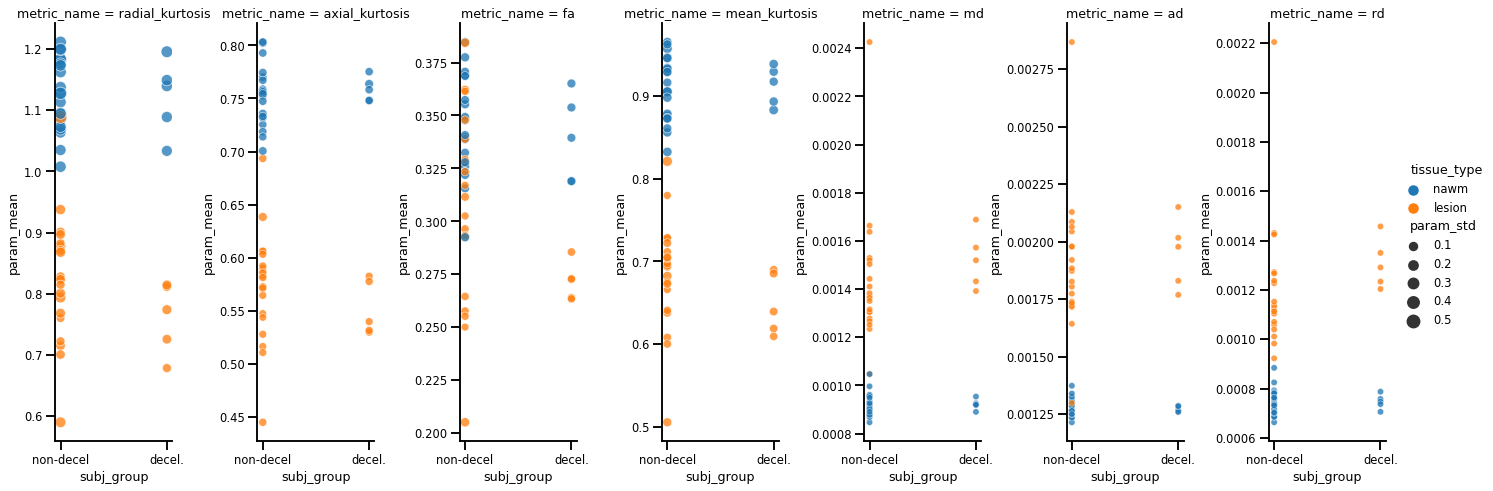

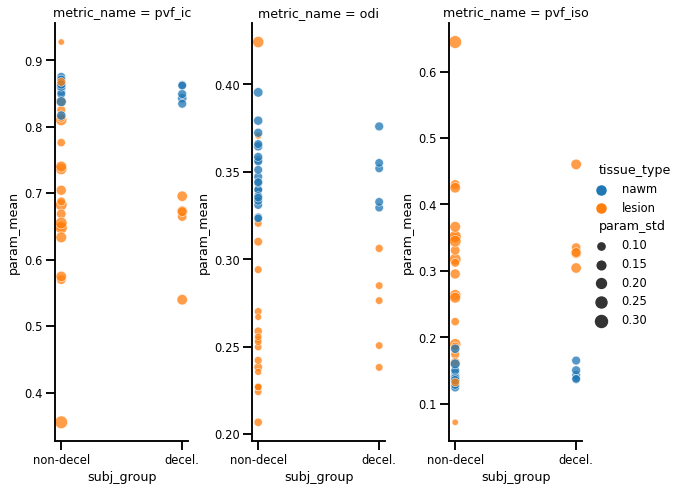

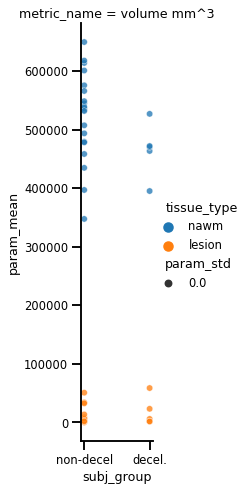

In [11]:
# Plot means & standard deviations for a set of parameter maps, showing differences
# between lesion vs. nawm, and decel. vs. non-decel.
with sns.plotting_context("talk", 0.7):
    for g in data_table.group.unique():
        d = d_sub.loc[d_sub.group == g, :]
        if d.shape[0] == 0:
            continue
        sns.relplot(
            data=d,
            x="subj_group",
            y="param_mean",
            hue="tissue_type",
            size="param_std",
            col="metric_name",
            aspect=0.4,
            height=7,
            facet_kws={"sharey": False, "sharex": True},
            alpha=0.76,
        )
        plt.show()

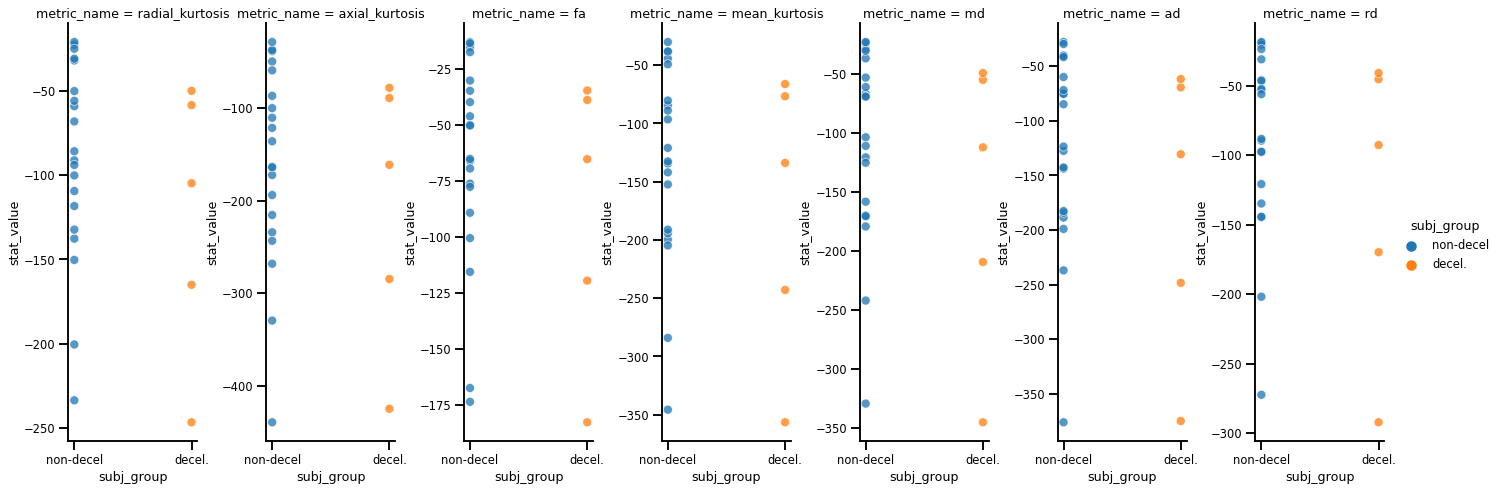

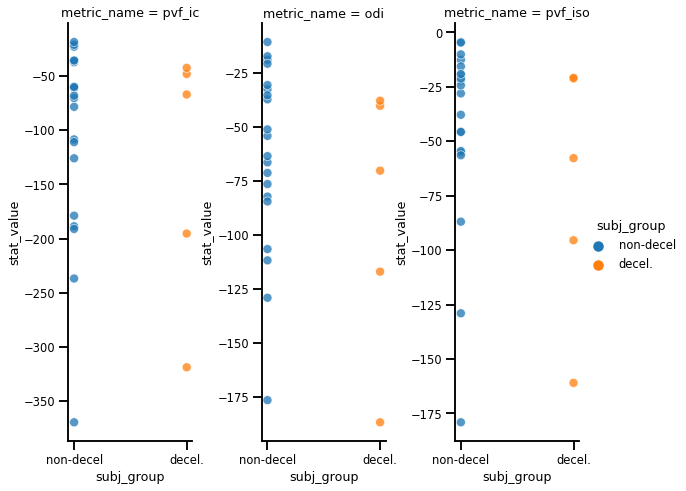

In [12]:
# Plot t-scores for all subjects over the chosen metrics, split by decel vs. non-decel.
with sns.plotting_context("talk", 0.7):
    for g in stats_table.group.unique():
        s = s_sub.loc[s_sub.group == g, :]
        if s.shape[0] == 0:
            continue
        sns.relplot(
            data=s,
            x="subj_group",
            y="stat_value",
            hue="subj_group",
            col="metric_name",
            aspect=0.4,
            height=7,
            facet_kws={"sharey": False, "sharex": True},
            alpha=0.76,
        )
        plt.show()

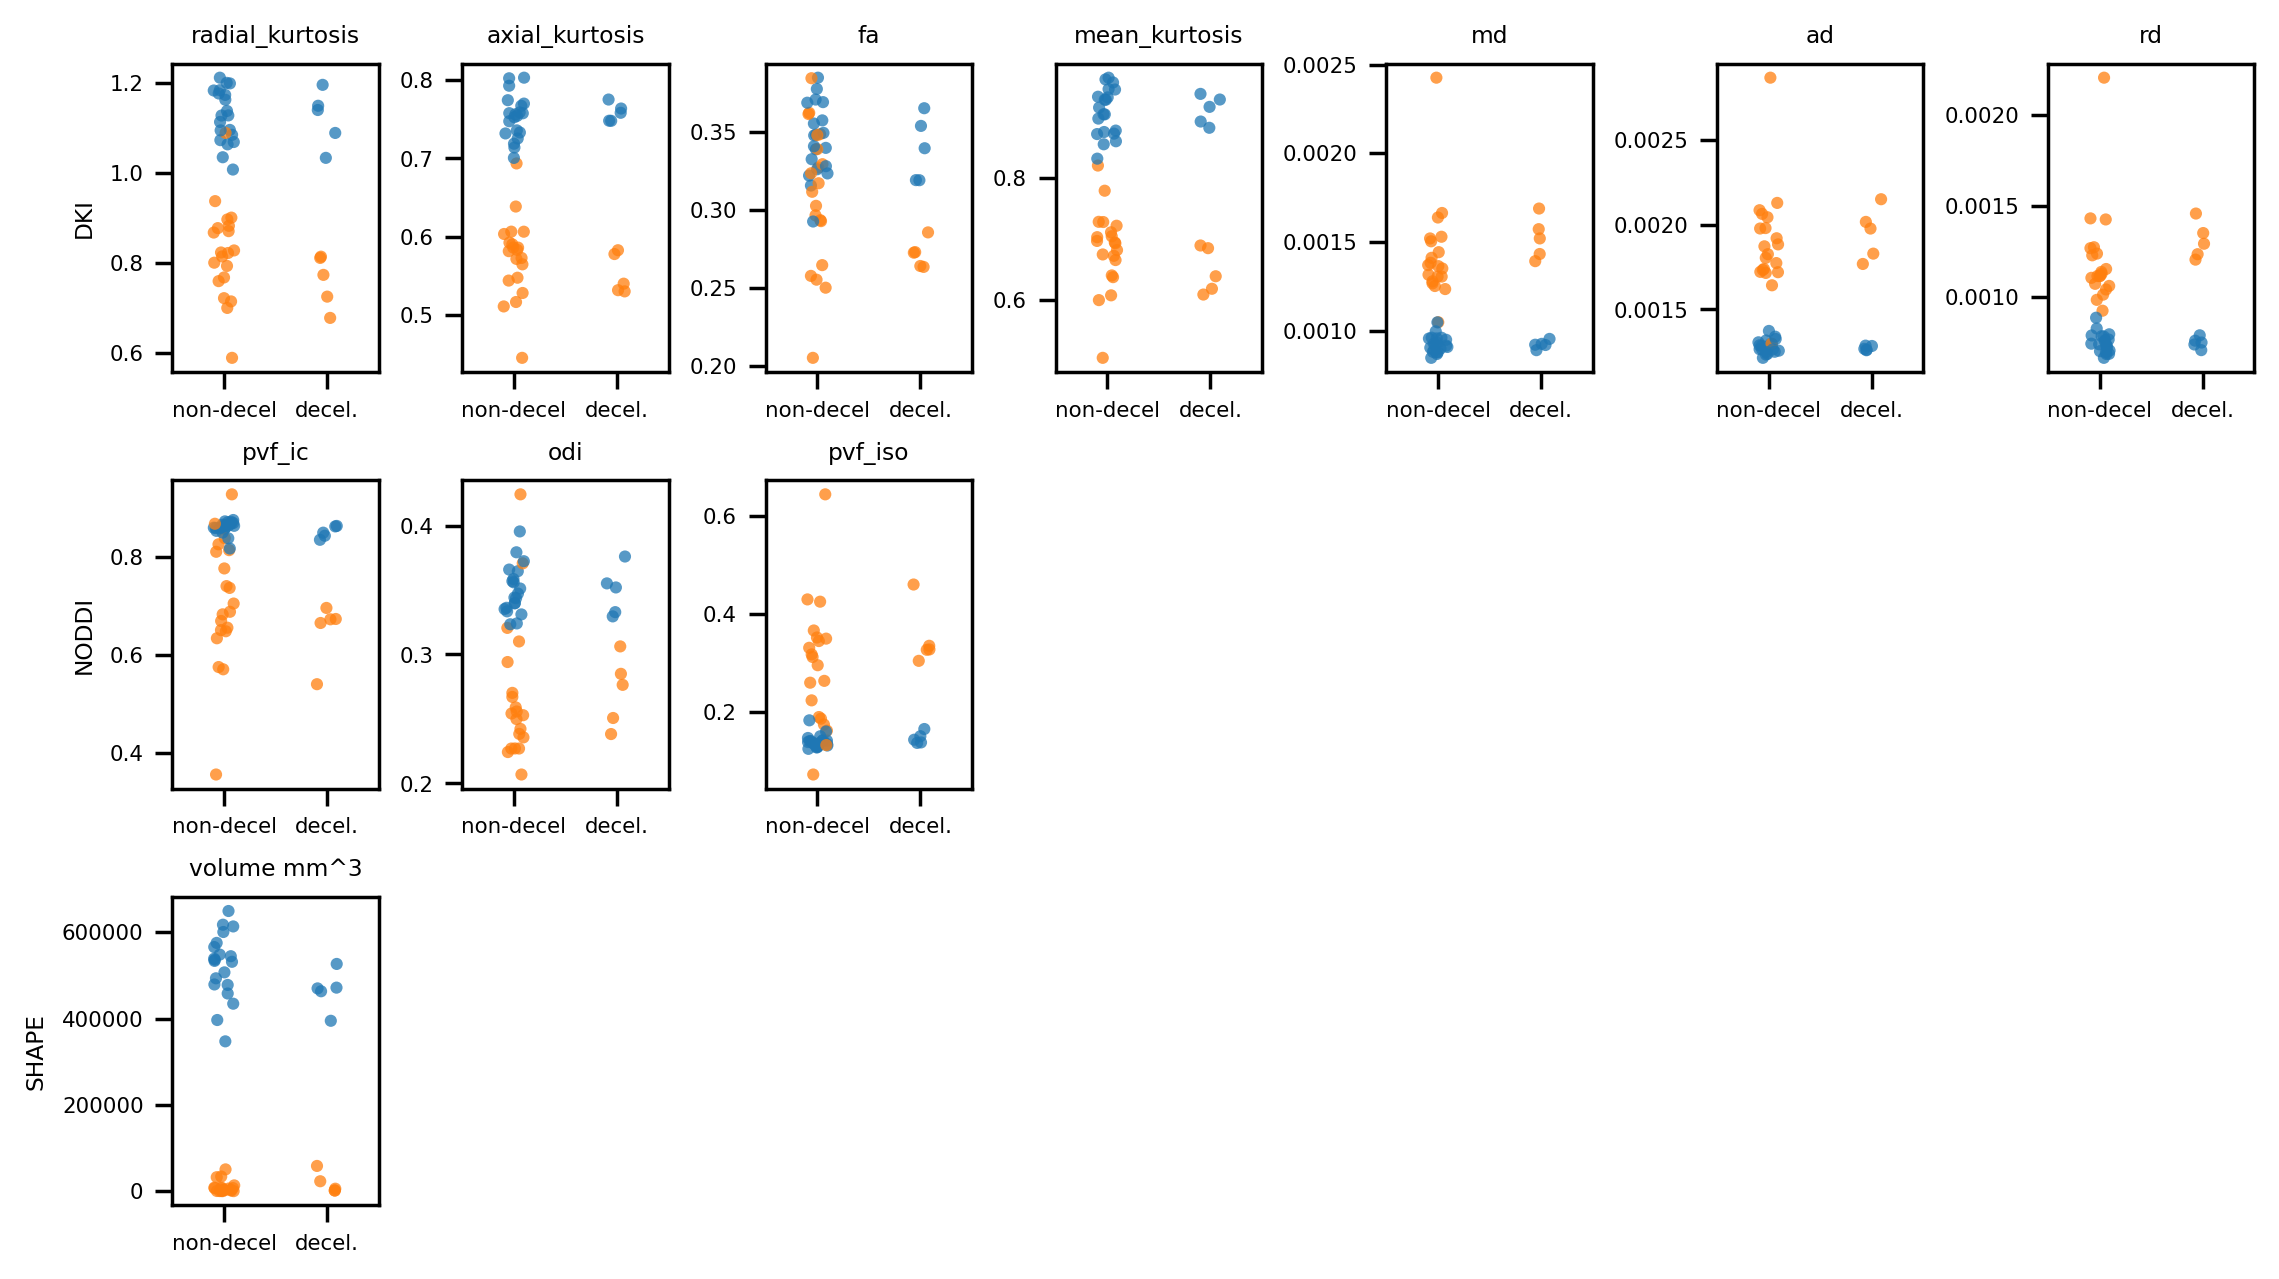

In [13]:
# Re-create the {nawm, lesion} x {non-decel, decel} metric comparison plot above, but
# in one figure.

n_groups = len(d_sub.group.unique())

max_num_metrics = 0
for g in d_sub.group.unique():
    d = d_sub.loc[d_sub.group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))


with sns.plotting_context("paper", 0.7):
    fig = plt.figure(dpi=250, figsize=(9, 5), layout="constrained")
    gs = mpl.gridspec.GridSpec(nrows=n_groups, ncols=max_num_metrics, figure=fig)

    # Iterate over rows/groups
    for i_g, g in enumerate(d_sub.group.unique()):
        d_g = d_sub.loc[d_sub.group == g, :]
        # Iterate over variable-length columns/metrics
        for j_m, m in itertools.zip_longest(
            range(max_num_metrics), d_g.metric_name.unique(), fillvalue=None
        ):
            if m is None:
                break
            ax = fig.add_subplot(gs[i_g, j_m])
            d = d_g.loc[d_g.metric_name == m, :]
            if d.shape[0] == 0:
                continue
            ax = sns.stripplot(
                d,
                x="subj_group",
                y="param_mean",
                hue="tissue_type",
                size=3.5,
                alpha=0.75,
                jitter=True,
                ax=ax,
                legend=False,
            )
            ax.set_title(m)
            if j_m == 0:
                ax.set_ylabel(g.upper())
            else:
                ax.set_ylabel(None)
            ax.set_xlabel(None)
            # sns.relplot(
            #     data=d,
            #     x="subj_group",
            #     y="param_mean",
            #     hue="tissue_type",
            #     size="param_std",
            #     col="metric_name",
            #     aspect=0.4,
            #     height=7,
            #     facet_kws={"sharey": False, "sharex": True},
            #     alpha=0.76,
            # )
plt.show()

### Distribution Comparisons

In [77]:
metrics_of_interest = (
    "pvf_ic",
    "pvf_iso",
    "odi",
    "fa",
    "md",
    "ad",
    "adc",
    "rd",
    "mean_kurtosis",
    "radial_kurtosis",
    "axial_kurtosis",
    "kurtosis_fa",
)
groups_of_interest = ("dki", "noddi", "dti")

d_sub_dist = data_table[
    data_table.group.isin(groups_of_interest)
    & data_table.metric_name.isin(metrics_of_interest)
]

s_sub_dist = stats_table[
    stats_table.group.isin(groups_of_interest)
    & stats_table.metric_name.isin(metrics_of_interest)
]

n_groups = len(d_sub_dist.group.unique())

max_num_metrics = 0
for g in d_sub_dist.group.unique():
    d = d_sub_dist.loc[d_sub_dist.group == g, :]
    max_num_metrics = max(max_num_metrics, len(d.metric_name.unique()))

dki - radial_kurtosis
dki - axial_kurtosis
dki - fa
dki - kurtosis_fa
dki - mean_kurtosis
dki - md
dki - ad
dki - rd
dti - fa
dti - adc
dti - ad
dti - rd
noddi - pvf_ic
noddi - odi
noddi - pvf_iso


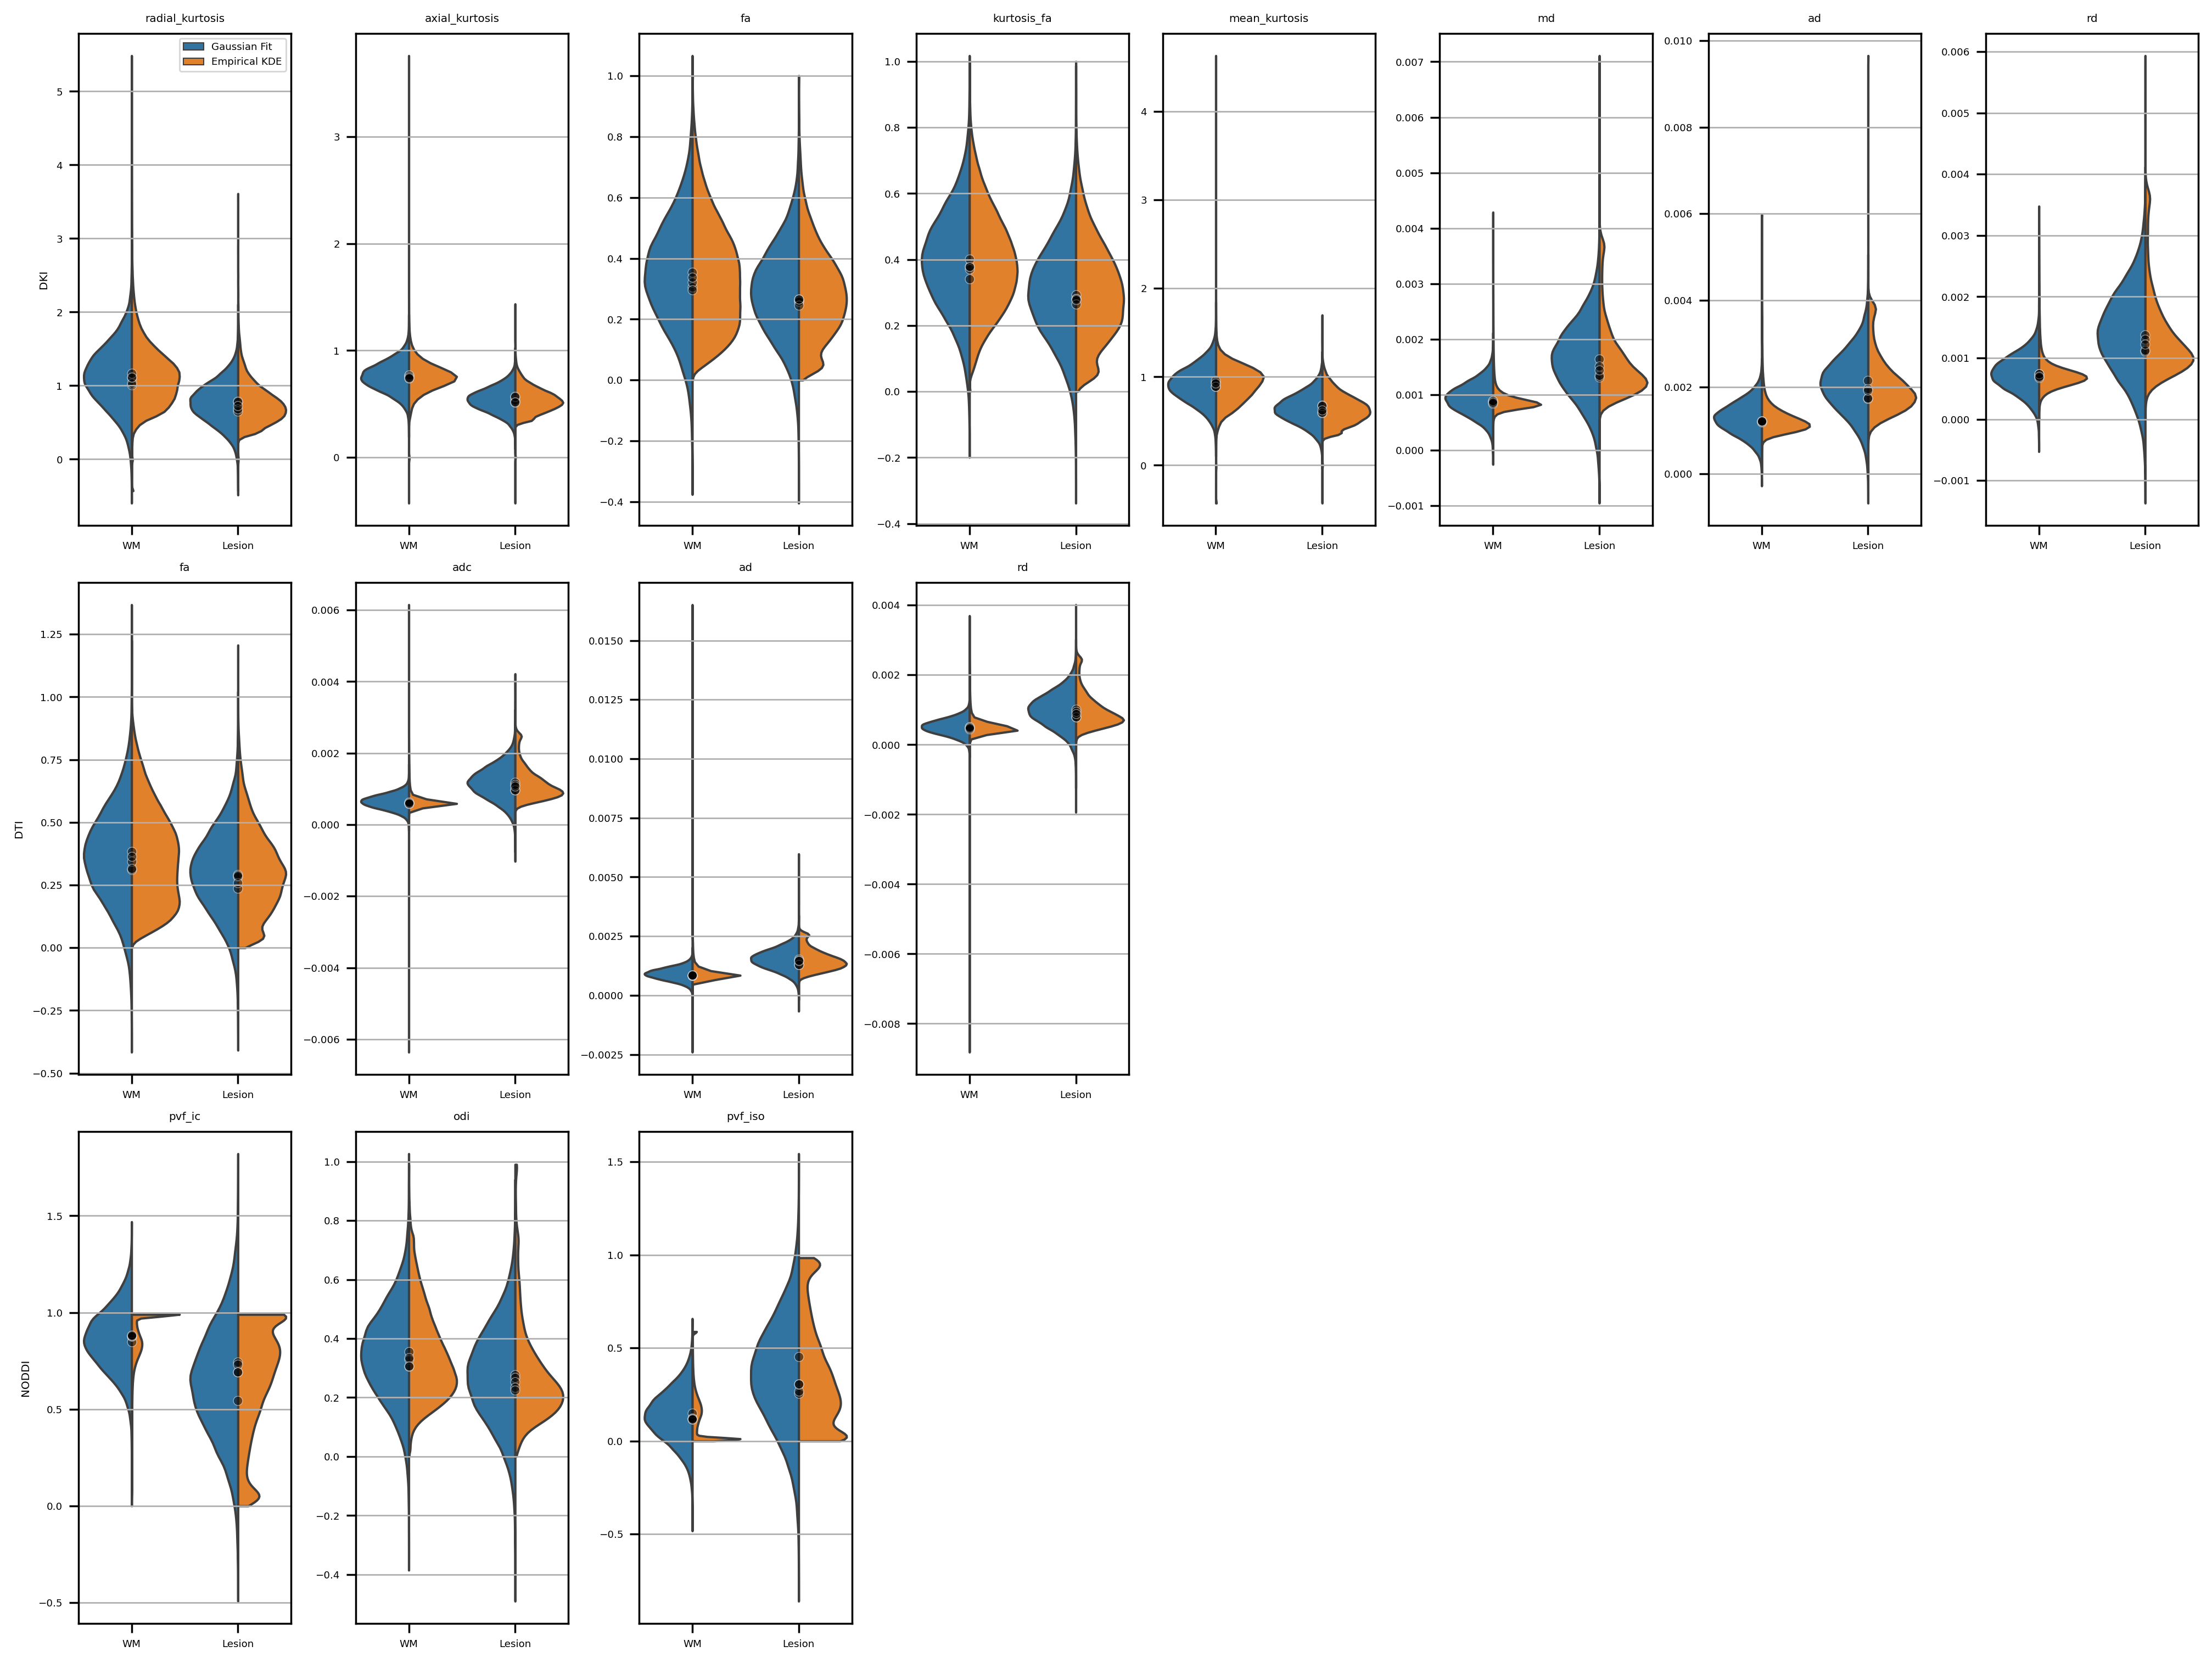

In [87]:
# Grid of decel individuals vs. non-decel distributions
with sns.plotting_context("paper", 0.6):
    fig = plt.figure(
        dpi=250, figsize=(max_num_metrics * 2, n_groups * 4), layout="constrained"
    )
    gs = mpl.gridspec.GridSpec(nrows=n_groups, ncols=max_num_metrics, figure=fig)

    # Iterate over rows/groups
    for i_g, g in enumerate(d_sub_dist.group.unique()):
        d_g = d_sub_dist.loc[d_sub_dist.group == g, :]
        # Iterate over variable-length columns/metrics
        for j_m, m in itertools.zip_longest(
            range(max_num_metrics), d_g.metric_name.unique(), fillvalue=None
        ):
            if m is None:
                break
            ax = fig.add_subplot(gs[i_g, j_m])
            d = d_g.loc[d_g.metric_name == m, :]
            if d.shape[0] == 0:
                continue

            # Revert the naming cleanup to get back the filenames.
            if m == "odi":
                m_orig = "wm-Watson-bundle_odi"
            elif m == "pvf_ic":
                m_orig = "partial_volume_fraction_wm-intra-cellular-Watson-bundle"
            elif m == "pvf_iso":
                m_orig = "partial_volume_fraction_csf-isotropic-ball"
            elif m == "pvf_ic-stick":
                m_orig = "normalized_partial_volume_fraction_intra-axonal-stick_within-wm-Watson-bundle"
            else:
                m_orig = m

            pooled_nondecel_wm = list()
            pooled_nondecel_lesion = list()
            pooled_decel_wm_stats = list()
            pooled_decel_lesion_stats = list()
            for subj_id in subj_list:
                d_files = subj_data[subj_id].files
                lesion_mask = (
                    nib.load(d_files.diffusion.lesion_mask).get_fdata().astype(bool)
                )
                wm_mask = nib.load(d_files.diffusion.wm_mask).get_fdata().astype(bool)
                wm_mask = wm_mask * (~lesion_mask)

                p_f = d_files.diffusion.param_maps[g][m_orig]
                p_im = nib.load(p_f).get_fdata().astype(np.float32)
                # Ignore multi-dimensional parameters for now.
                if len(p_im.shape) == 4:
                    continue
                if subj_id in decel_subjs:
                    wm_stat = np.nanmedian(p_im[wm_mask])
                    lesion_stat = np.nanmedian(p_im[lesion_mask])
                    pooled_decel_wm_stats.append(wm_stat)
                    pooled_decel_lesion_stats.append(lesion_stat)
                else:
                    pooled_nondecel_wm.append(p_im[wm_mask])
                    pooled_nondecel_lesion.append(p_im[lesion_mask])

            pooled_nondecel_wm = np.concatenate(pooled_nondecel_wm).flatten()
            pooled_nondecel_wm = np.clip(
                pooled_nondecel_wm, a_min=None, a_max=5 * np.median(pooled_nondecel_wm)
            )

            pooled_nondecel_lesion = np.concatenate(pooled_nondecel_lesion).flatten()
            pooled_nondecel_lesion = np.clip(
                pooled_nondecel_lesion,
                a_min=None,
                a_max=5 * np.median(pooled_nondecel_lesion),
            )
            pooled_decel_wm_stats = np.array(pooled_decel_wm_stats).flatten()
            pooled_decel_lesion_stats = np.array(pooled_decel_lesion_stats).flatten()

            nondecel_wm_mean = np.nanmean(pooled_nondecel_wm)
            nondecel_wm_std = np.nanstd(pooled_nondecel_wm)
            nondecel_lesion_mean = np.nanmean(pooled_nondecel_lesion)
            nondecel_lesion_std = np.nanstd(pooled_nondecel_lesion)
            wm_rv = scipy.stats.norm(loc=nondecel_wm_mean, scale=nondecel_wm_std)
            wm_x = wm_rv.rvs(50000)
            lesion_rv = scipy.stats.norm(
                loc=nondecel_lesion_mean, scale=nondecel_lesion_std
            )
            lesion_x = lesion_rv.rvs(50000)

            nondecel_y = list()
            nondecel_x = list()
            nondecel_dist_source = list()
            nondecel_y.append(wm_x)
            nondecel_x.extend(["WM"] * len(wm_x))
            nondecel_dist_source.extend(["Gaussian Fit"] * len(wm_x))
            nondecel_y.append(pooled_nondecel_wm)
            nondecel_x.extend(["WM"] * len(pooled_nondecel_wm))
            nondecel_dist_source.extend(["Empirical KDE"] * len(pooled_nondecel_wm))
            nondecel_y.append(lesion_x)
            nondecel_x.extend(["Lesion"] * len(lesion_x))
            nondecel_dist_source.extend(["Gaussian Fit"] * len(lesion_x))
            nondecel_y.append(pooled_nondecel_lesion)
            nondecel_x.extend(["Lesion"] * len(pooled_nondecel_lesion))
            nondecel_dist_source.extend(["Empirical KDE"] * len(pooled_nondecel_lesion))
            nondecel_y = np.concatenate(nondecel_y).flatten()

            nondecel_data = pd.DataFrame.from_dict(
                {
                    "val": nondecel_y,
                    "tissue": nondecel_x,
                    "dist_source": nondecel_dist_source,
                }
            )

            # Plot decel subjects summary stat of choice.
            ax = sns.violinplot(
                nondecel_data,
                x="tissue",
                y="val",
                hue="dist_source",
                split=True,
                inner=None,
                legend=False,
                scale="width",
                width=0.9,
                ax=ax,
                cut=0,
            )
            violin_ymin, violin_ymax = ax.get_ylim()
            violin_xmin, violin_xmax = ax.get_xlim()

            ax = sns.scatterplot(
                x=["WM"] * len(pooled_decel_wm_stats),
                y=pooled_decel_wm_stats,
                ax=ax,
                color="black",
                alpha=0.5,
            )
            ax = sns.scatterplot(
                x=["Lesion"] * len(pooled_decel_lesion_stats),
                y=pooled_decel_lesion_stats,
                ax=ax,
                color="black",
                alpha=0.5,
            )

            ax.set_xlim(violin_xmin, violin_xmax)
            ax.set_ylim(violin_ymin, violin_ymax)
            ax.grid(axis="y", zorder=1)
            ax.set_title(m)
            if j_m == 0:
                ax.set_ylabel(g.upper())
            else:
                ax.set_ylabel(None)
            ax.set_xlabel(None)
            if i_g == j_m == 0:
                pass
            else:
                ax.get_legend().remove()
            print(g, "-", m)

plt.show()